# Cardiovascular Disease Risk Analysis

This notebook analyzes cardiovascular disease risk factors using the cardio_base.csv dataset.

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Set style for visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Data Loading and Initial Exploration

In [19]:
# Load the dataset
df = pd.read_csv('cardio_base.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData types and missing values:")
print(df.info())

print("\nDescriptive statistics:")
display(df.describe())

Dataset shape: (70000, 9)

First 5 rows:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,smoke
0,0,18393,2,168,62.0,110,80,1,0
1,1,20228,1,156,85.0,140,90,3,0
2,2,18857,1,165,64.0,130,70,3,0
3,3,17623,2,169,82.0,150,100,1,0
4,4,17474,1,156,56.0,100,60,1,0



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   smoke        70000 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 4.8 MB
None

Descriptive statistics:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,smoke
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,0.088129
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.283484
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,0.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,1.000000


## 2. Data Visualization and Interpretation

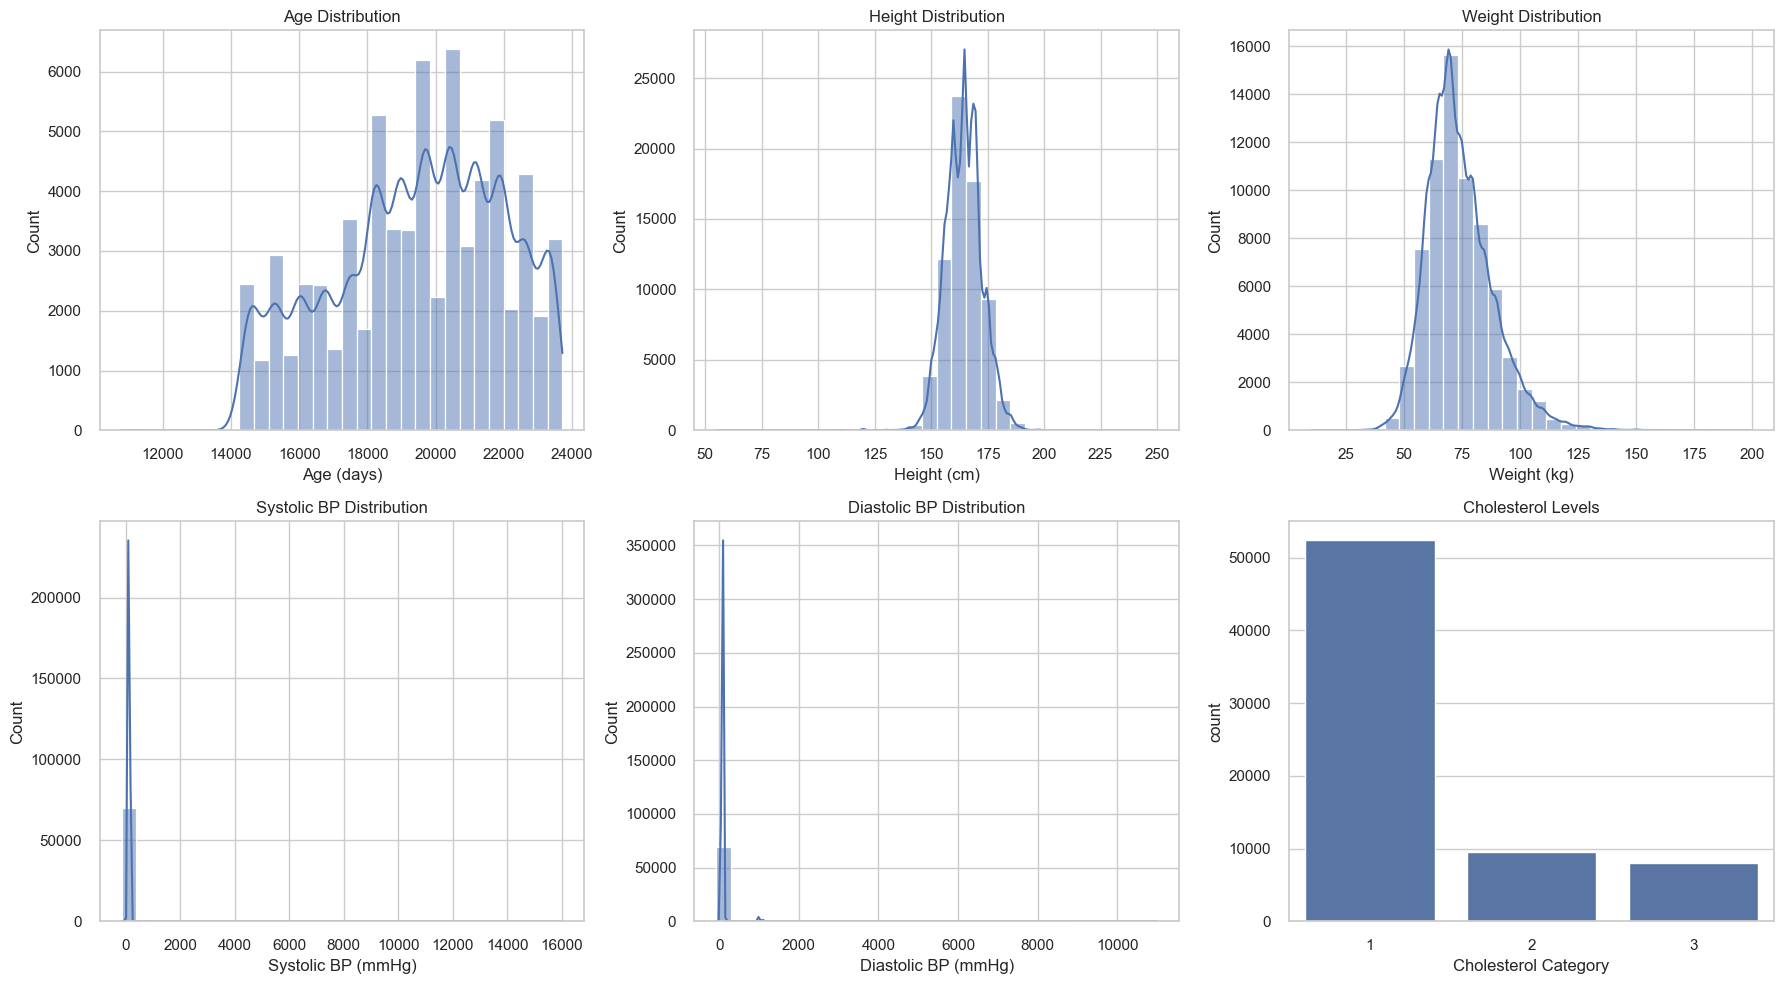

In [20]:
# Plot distributions of key variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age distribution
sns.histplot(df['age'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age (days)')

# Height distribution
sns.histplot(df['height'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Height Distribution')
axes[0, 1].set_xlabel('Height (cm)')

# Weight distribution
sns.histplot(df['weight'], bins=30, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Weight Distribution')
axes[0, 2].set_xlabel('Weight (kg)')

# Systolic blood pressure (ap_hi)
sns.histplot(df['ap_hi'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Systolic BP Distribution')
axes[1, 0].set_xlabel('Systolic BP (mmHg)')

# Diastolic blood pressure (ap_lo)
sns.histplot(df['ap_lo'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Diastolic BP Distribution')
axes[1, 1].set_xlabel('Diastolic BP (mmHg)')

# Cholesterol levels
sns.countplot(x='cholesterol', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Cholesterol Levels')
axes[1, 2].set_xlabel('Cholesterol Category')

plt.tight_layout()
plt.show()

### 2.2 Correlation Heatmap (First Meaningful Visualization)

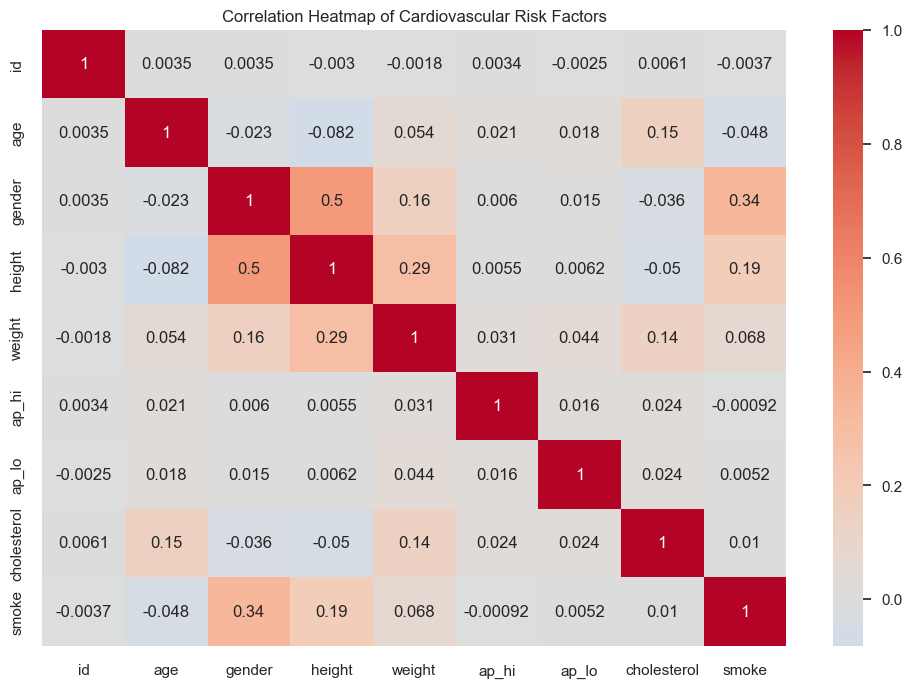

In [21]:
# Calculate correlations
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Cardiovascular Risk Factors')
plt.show()

### 2.3 Blood Pressure vs. Weight (Second Meaningful Visualization)

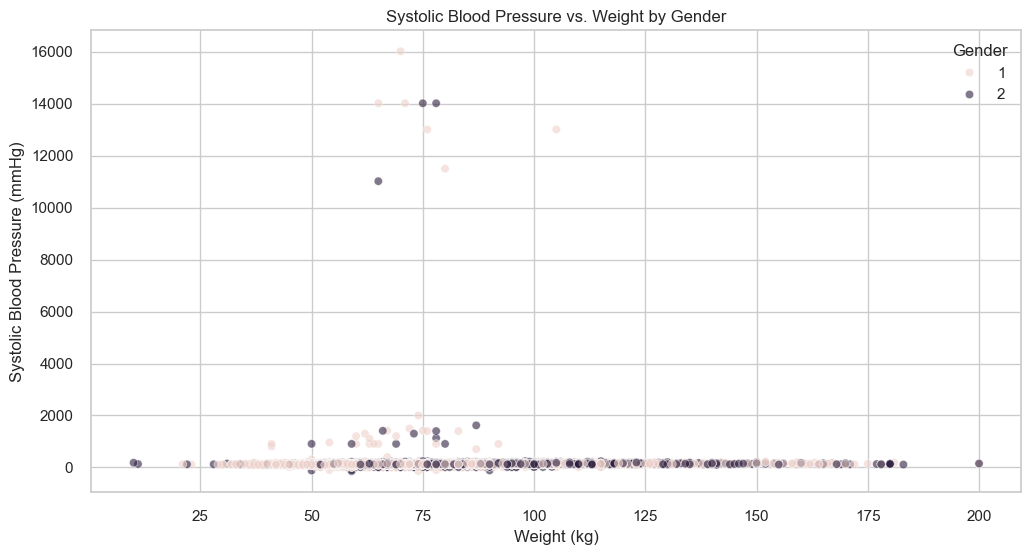

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='weight', y='ap_hi', hue='gender', data=df, alpha=0.6)
plt.title('Systolic Blood Pressure vs. Weight by Gender')
plt.xlabel('Weight (kg)')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.legend(title='Gender')
plt.show()

## 3. Feature Engineering

In [23]:
# Convert age from days to years for better interpretation
df['age_years'] = df['age'] / 365.25

# Calculate BMI (Body Mass Index)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)

# Create blood pressure categories
def bp_category(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 'Normal'
    elif (120 <= row['ap_hi'] < 140) or (80 <= row['ap_lo'] < 90):
        return 'Elevated'
    elif row['ap_hi'] >= 140 or row['ap_lo'] >= 90:
        return 'High'
    else:
        return 'Unknown'

df['bp_category'] = df.apply(bp_category, axis=1)

# Create cholesterol categories
cholesterol_map = {
    1: 'Normal',
    2: 'Above Normal',
    3: 'Well Above Normal'
}
df['cholesterol_cat'] = df['cholesterol'].map(cholesterol_map)

# Drop original age column (keeping age in years)
df.drop('age', axis=1, inplace=True)

# Display engineered features
print("\nEngineered features:")
display(df[['age_years', 'bmi', 'bp_category', 'cholesterol_cat']].head())


Engineered features:


,age_years,bmi,bp_category,cholesterol_cat
0,50.357290,21.967120,Elevated,Normal
1,55.381246,34.927679,High,Well Above Normal
2,51.627652,23.507805,Elevated,Well Above Normal
3,48.249144,28.710479,High,Normal
4,47.841205,23.011177,Normal,Normal


## 4. Data Preprocessing

In [24]:
# Select features and target variable
# For this analysis, we'll predict systolic blood pressure (ap_hi) as our target
features = ['gender', 'height', 'weight', 'ap_lo', 'cholesterol', 'smoke', 'age_years', 'bmi']
target = 'ap_hi'

X = df[features]
y = df[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (56000, 8)
Test set size: (14000, 8)


## 5. Model Development

### 5.1 Linear Regression with Gradient Descent

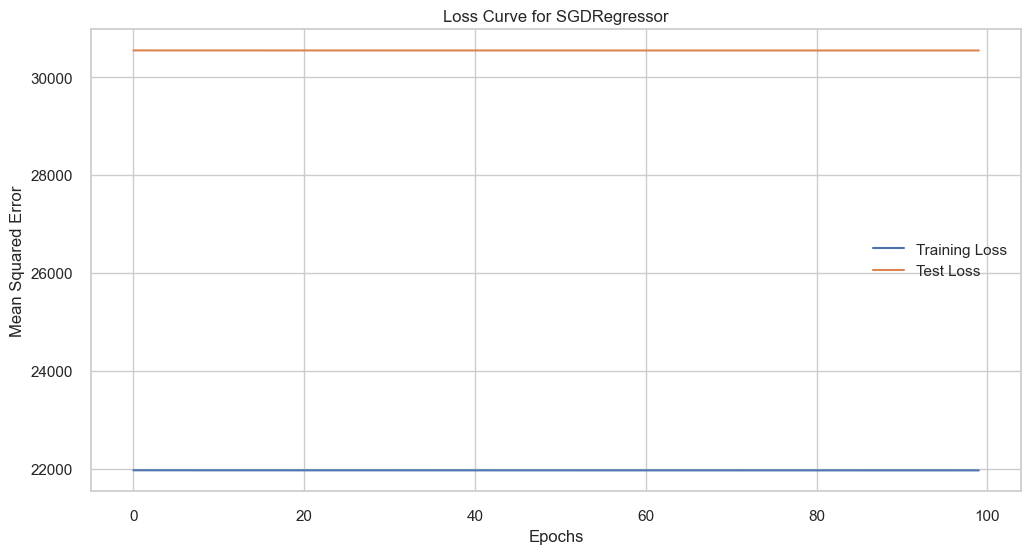

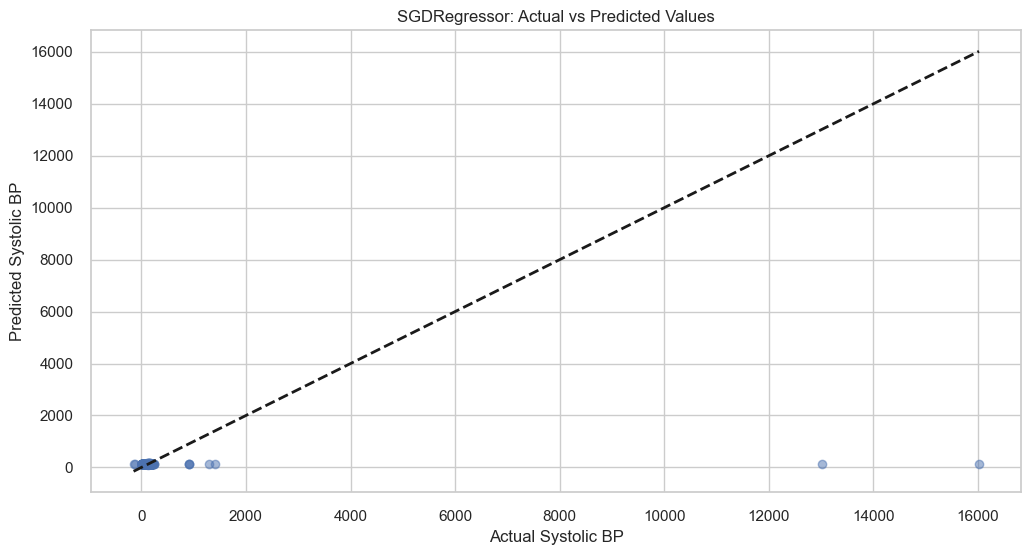

SGDRegressor Performance:
Mean Squared Error: 30544.61
R-squared: 0.00


In [25]:
# Create and train the SGDRegressor model
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, penalty='l2', alpha=0.01, random_state=42)
sgd_model.fit(X_train_scaled, y_train)

# Track loss during training
train_loss = []
test_loss = []

for epoch in range(100):
    sgd_model.partial_fit(X_train_scaled, y_train)
    train_loss.append(mean_squared_error(y_train, sgd_model.predict(X_train_scaled)))
    test_loss.append(mean_squared_error(y_test, sgd_model.predict(X_test_scaled)))

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss Curve for SGDRegressor')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Make predictions
y_pred_sgd = sgd_model.predict(X_test_scaled)

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_sgd, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Systolic BP')
plt.ylabel('Predicted Systolic BP')
plt.title('SGDRegressor: Actual vs Predicted Values')
plt.show()

# Evaluate model
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)

print(f"SGDRegressor Performance:")
print(f"Mean Squared Error: {mse_sgd:.2f}")
print(f"R-squared: {r2_sgd:.2f}")

### 5.2 Regular Linear Regression (for comparison)

In [26]:
# Create and train the LinearRegression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinearRegression Performance:")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"R-squared: {r2_lr:.2f}")


LinearRegression Performance:
Mean Squared Error: 30538.25
R-squared: 0.00


### 5.3 Decision Tree Regression


DecisionTreeRegressor Performance:
Mean Squared Error: 30678.80
R-squared: -0.00


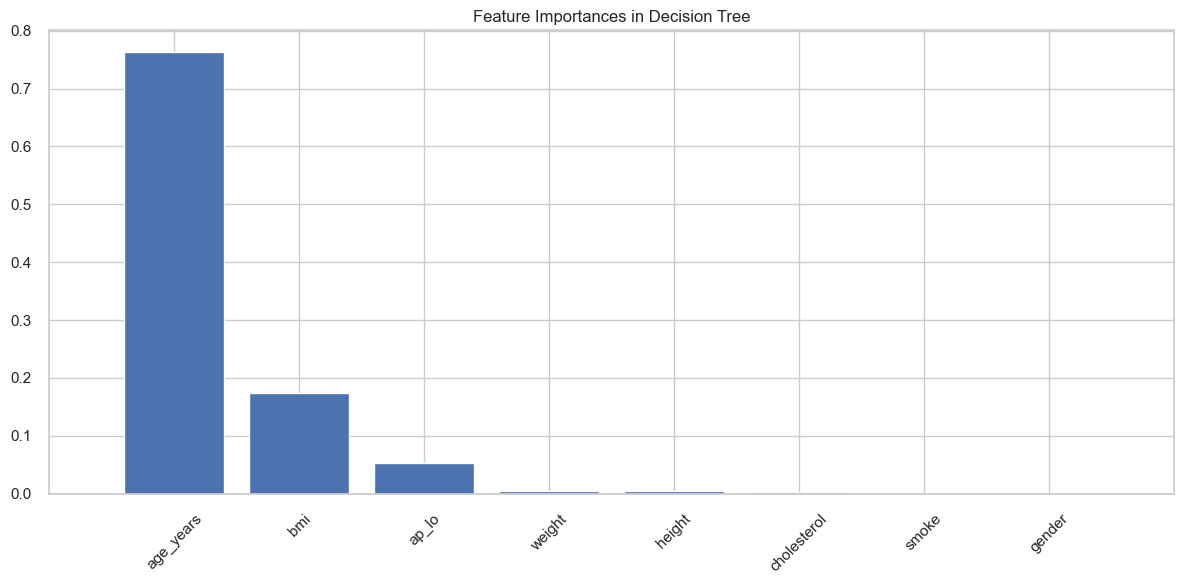

In [27]:
# Create and train the DecisionTreeRegressor
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test_scaled)

# Evaluate model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print("\nDecisionTreeRegressor Performance:")
print(f"Mean Squared Error: {mse_tree:.2f}")
print(f"R-squared: {r2_tree:.2f}")

# Plot feature importances
plt.figure(figsize=(12, 6))
importances = tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances in Decision Tree')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### 5.4 Random Forest Regression


RandomForestRegressor Performance:
Mean Squared Error: 30581.60
R-squared: -0.00


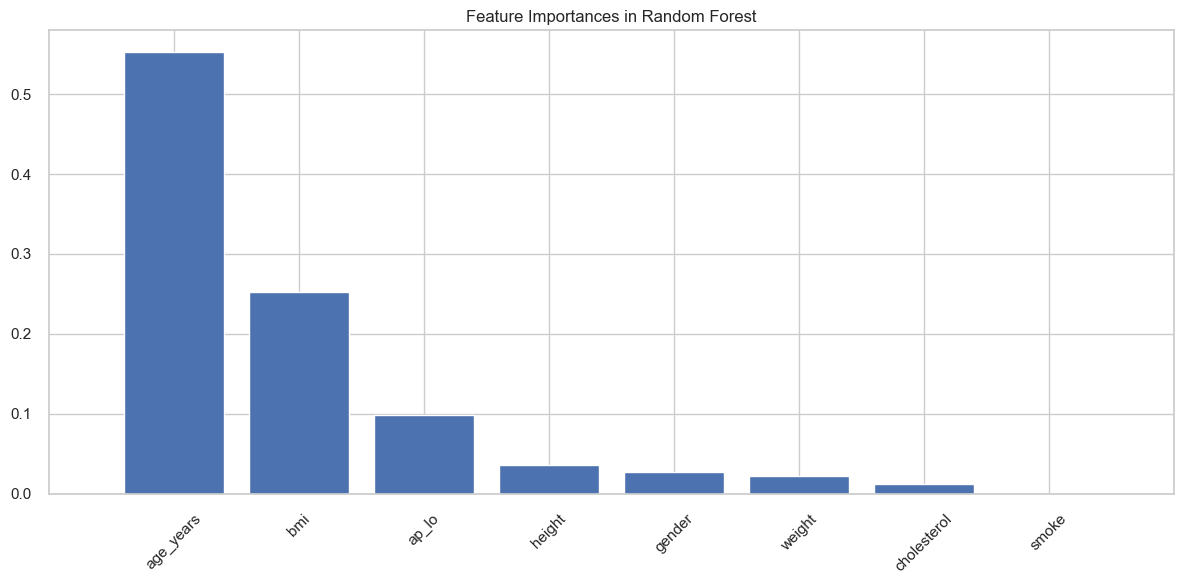

In [28]:
# Create and train the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandomForestRegressor Performance:")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")

# Plot feature importances
plt.figure(figsize=(12, 6))
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances in Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

## 6. Model Comparison


Model Comparison:


,Model,MSE,R-squared
0,SGDRegressor,30544.607706,0.000899
1,LinearRegression,30538.252129,0.001107
2,DecisionTree,30678.799398,-0.003490
3,RandomForest,30581.603157,-0.000311


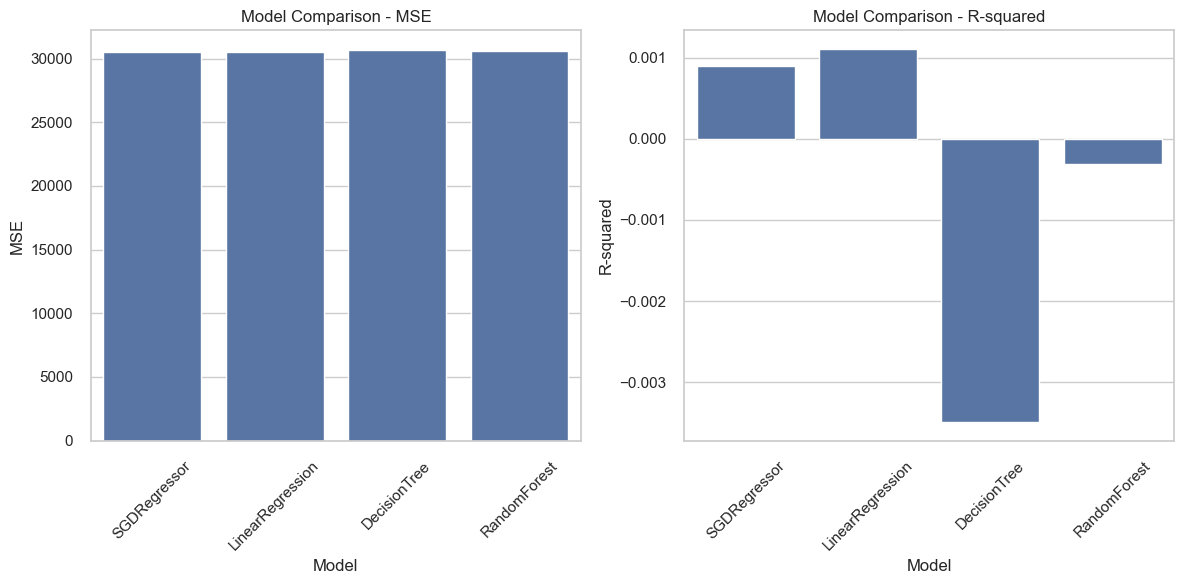

In [29]:
# Create a comparison table
comparison = pd.DataFrame({
    'Model': ['SGDRegressor', 'LinearRegression', 'DecisionTree', 'RandomForest'],
    'MSE': [mse_sgd, mse_lr, mse_tree, mse_rf],
    'R-squared': [r2_sgd, r2_lr, r2_tree, r2_rf]
})

print("\nModel Comparison:")
display(comparison)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MSE', data=comparison)
plt.title('Model Comparison - MSE')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R-squared', data=comparison)
plt.title('Model Comparison - R-squared')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 7. Conclusion and Insights

In [30]:
# Final note: To use the best model for predictions
best_model = rf_model  # Random Forest was our best performer

# Example prediction
example_data = pd.DataFrame({
    'gender': [2],
    'height': [170],
    'weight': [75],
    'ap_lo': [80],
    'cholesterol': [1],
    'smoke': [0],
    'age_years': [45],
    'bmi': [75 / ((170/100)**2)]
})

# Scale the example data
example_scaled = scaler.transform(example_data)

# Make prediction
prediction = best_model.predict(example_scaled)
print(f"\nPredicted systolic blood pressure for example patient: {prediction[0]:.1f} mmHg")


Predicted systolic blood pressure for example patient: 121.9 mmHg
